## 루브릭
|평가문항|상세기준|
|:-----|:---|
|1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.|분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.|
|2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.|모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다.|
|3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.|두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.|


# Step1. 데이터 수집하기
---
데이터 다운로드


In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
90928,Ola driver arrested for molesting a woman in M...,The Mumbai Police has arrested an Ola cab driv...
76499,Deepika enjoys shopping & dining Ã¢ÂÂExperie...,Axis Bank recently launched its 'Experience Ax...
74393,"Overloading, unsafe helipads led to chopper mi...",After Maharashtra Chief Minister Devendra Fadn...
17047,Pak has to understand how to behave with neigh...,"Addressing the media on Monday, Home Minister ..."
61355,B'luru unsuitable for those with respiratory a...,BengaluruÃ¢ÂÂs doctors said it is not suitab...
38413,17-yr-old hits 232*(145) in an ODI to break 21...,New Zealand Women's 17-year-old spinner Amelia...
89837,Modi to address nation on completion of 3 year...,PM Narendra Modi will address the nation on Ma...
89738,Sagarika Ghatge shares pic with fiancÃÂ© Zahe...,"Actress Sagarika Ghatge, known for her perform..."
50503,"Opp'n held rally to save party, not Constituti...",Targeting the Opposition's 'Save the Constitut...
79153,Maanayata dances to Despacito with son on her ...,Actor Sanjay Dutt's wife Maanayata Dutt has sh...


# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

---
### 2_1.중복 샘플과 NULL 값이 존재하는 샘플 제거


In [4]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# 중복샘플 데이터 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
# 데이터 프레임에 NULL값 있는지 확인
print(data.isnull().sum()) 

headlines    0
text         0
dtype: int64


### 2_2. 텍스트 정규화와 불용어 제거
    텍스트 정규화 : 같은 의미인데 다른 표현으로 쓰여지는 단어를 통일 시켜주는 과정
---
#### 2_2_1.텍스트 정규화 사전 만들기

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


#### 2_2_2. 불용어 제거하기
    불용어:텍스트에는 자주 등장하지만 자연어 처리 시 실질적으로 도움이 되지 않는 단어
    ->NLTK에서 미리 정의하여 제공하고 있는 불용어(179개) 사용

In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 2_2_3. 데이터 전처리
    - 모든 영어 문자를 소문자로 만듬
    - 섞여있는 html 태그 제거
    - 정규 표현식을 통해 각종 특수문자 제거
    
    -def preprocess_sentence()
        * 하단 )NLTK를 이용해 불용어를 제거하는 파트가 있음
        =>Text 전처리 시에서만 호출 & 상대적으로 문장 길이가 짧을  Summary 전처리할 때는 호출하지 않을 것
        - 예측한 문장 요약 결과문이 자연스러원지기 위해 불용어들이  Summary에는 남아 있는 게 더 좋을 것 같음
        
#####  요약전 데이터는 불용어를 제거해주고 생성된 요약에서는 불용어를 제거해주지 않음  =>이유는 더 자연스러운 문장을 만들기 위해

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

#### 2_2_4. 훈련 데이터 전처리 수행
    :Text의 경우에는 불용어를 제거해야하고 Summary는 불용어를 제거하지 않은 상태에서 사용할 것임으로 따로 호출해서 진행해야 함

In [10]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [11]:
#이제 headlines에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 False를 넣어줄게요.
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


#### 2_2_5. 전처리 후 빈 샘플이 생겼는지 확인하기
    이유) 데이터 정제 전에는 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지면서 샘플 자체가 비어 버리는 경우가 있을 수 있기 때문이다.
    
---
        
    - 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체
    -.isnull().sum()을 이용하여 Null 값이 생성되었는지 확인
    - 새로 생성된 Null 값을 dropna를 이용해서 제거한다.

In [12]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True) # 빈 값을 가진 샘플들은 모두 Null 값을 가진 샘플로 대체

In [13]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [14]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 데이터 세트 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


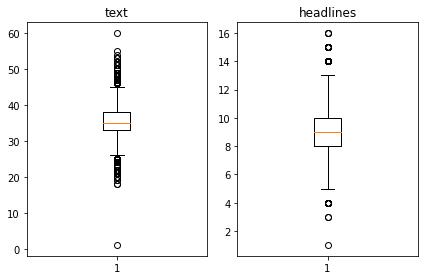

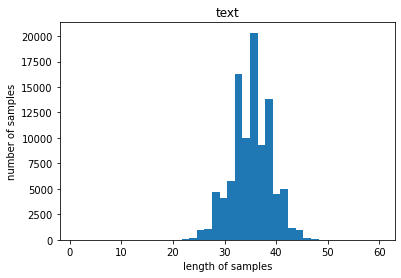

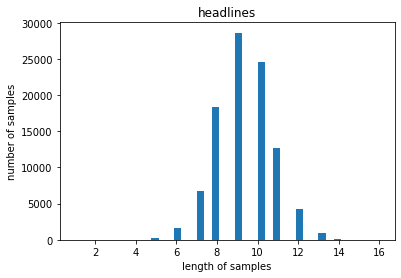

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [48]:
#수정해보기 한 42 랑 9로?
text_max_len = 42
headlines_max_len = 9

In [49]:
# 데이터의 몇 %에 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [50]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 42 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.6947315861920056


In [51]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 51481


## 토큰 추가하기

In [52]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
18,how long can tolerate congress leaders potshot...,days threatened step post congress mlas contin...,sostoken how long can tolerate congress leader...,how long can tolerate congress leaders potshot...
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
20,think the opposition even dreams about me pm modi,claiming dearth ideas among opposition parties...,sostoken think the opposition even dreams abou...,think the opposition even dreams about me pm m...


In [53]:
# 인코더의 입력, 디코더의 입력과 레이블을 넘파이 타입으로 저장

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [54]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 3902  6010 30351 ...  1426  7677 17143]


In [55]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 10296


In [56]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 41185
훈련 레이블의 개수 : 41185
테스트 데이터의 개수 : 10296
테스트 레이블의 개수 : 10296


## 정수 인코딩

In [57]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [58]:
# 빈도수가 적은 단어 제거
threshold = 8  # 빈도수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 53947
등장 빈도가 7번 이하인 희귀 단어의 수: 38849
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15098
단어 집합에서 희귀 단어의 비율: 72.01327228576196
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.971195705955053


In [59]:
src_vocab = 18000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [60]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[11306, 420, 11307, 1977, 14101, 629, 6, 16, 118, 40, 245, 1274, 414, 898, 79, 460, 277, 21, 352, 11307, 243, 286, 1157, 40, 14101, 7460, 8, 529, 676, 192, 3909], [5052, 1369, 9199, 456, 10348, 388, 12, 1736, 1586, 193, 12547, 5503, 128, 3630, 2536, 676, 7071, 7071, 8335, 60, 456, 5052, 985, 5411, 2793, 12, 1535, 2016, 309, 12547, 1, 83, 15099, 3511, 2909], [348, 5504, 459, 2190, 1907, 94, 25, 1018, 6191, 563, 1645, 1007, 459, 41, 11842, 5593, 3866, 146, 890, 49, 1907, 9, 784, 1346, 1512, 6312, 17782, 2069, 526, 90, 3910, 1007]]


In [61]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [62]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 24125
등장 빈도가 6번 이하인 희귀 단어의 수: 17522
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6603
단어 집합에서 희귀 단어의 비율: 72.63005181347151
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.486794498837416


In [63]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4205, 321, 6605, 442, 13, 26, 3, 605], [1, 3753, 5517, 342, 2174, 954, 7343, 126], [1, 3401, 630, 521, 3, 1172, 11, 1004, 1382], [1, 4763, 707, 85, 305, 11, 1247, 4456], [1, 56, 216, 31, 2735, 493, 2629, 6001]]
target
decoder  [[4205, 321, 6605, 442, 13, 26, 3, 605, 2], [3753, 5517, 342, 2174, 954, 7343, 126, 2], [3401, 630, 521, 3, 1172, 11, 1004, 1382, 2], [4763, 707, 85, 305, 11, 1247, 4456, 2], [56, 216, 31, 2735, 493, 2629, 6001, 2]]


In [64]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 41185
훈련 레이블의 개수 : 41185
테스트 데이터의 개수 : 10295
테스트 레이블의 개수 : 10295


In [65]:
# 패딩하기
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [66]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256 # hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [67]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [68]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2304000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [69]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2304000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### EarlyStopping(조기 종료)
    - 코드에서 val_loss(검증 데이터 손실)이 줄어들지 않고 증가하는 현상이 patience(=2) 횟수 만큼 관측되면 학습을 멈추도록함
    - epochs가 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출수 있게 됨


In [70]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
161/161 [==============================] - 98s 560ms/step - loss: 6.5211 - val_loss: 6.0943
Epoch 2/50
161/161 [==============================] - 89s 556ms/step - loss: 6.0315 - val_loss: 5.8166
Epoch 3/50
161/161 [==============================] - 89s 552ms/step - loss: 5.7740 - val_loss: 5.5874
Epoch 4/50
161/161 [==============================] - 90s 556ms/step - loss: 5.5084 - val_loss: 5.3922
Epoch 5/50
161/161 [==============================] - 89s 554ms/step - loss: 5.2757 - val_loss: 5.2095
Epoch 6/50
161/161 [==============================] - 89s 552ms/step - loss: 5.0622 - val_loss: 5.0631
Epoch 7/50
161/161 [==============================] - 89s 555ms/step - loss: 4.8732 - val_loss: 4.9721
Epoch 8/50
161/161 [==============================] - 89s 554ms/step - loss: 4.7086 - val_loss: 4.8658
Epoch 9/50
161/161 [==============================] - 89s 554ms/step - loss: 4.5566 - val_loss: 4.7957
Epoch 10/50
161/161 [==============================] - 88s 546ms/step - l

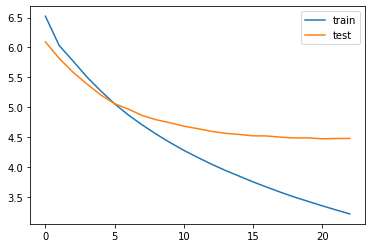

In [71]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델 구현하기


In [72]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [73]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [74]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [75]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [76]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해 실제 요약과 예측 요약을 비교

In [77]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : least people lost lives three days continuous heavy rainfall karnataka flood like situation state due increased water level krishna rivers landslides reported many districts along several instances severed road links submerged bridges 
실제 요약 : heavy rainfall claims lives in karnataka 
예측 요약 :  killed in assam floods in assam


원문 : study found water brahmaputra river could turning black due recent earthquake tibet union minister arjun ram meghwal said river southern tibet becomes brahmaputra enters arunachal pradesh central water commission started looking matter minister added 
실제 요약 : brahmaputra water turning black due to tibet quake minister 
예측 요약 :  scientists identify green plant plant


원문 : group volunteers charged offences us city el feeding homeless people park police said volunteers violated ordinance passed october prohibiting food sharing homeless individuals public spaces ban aims tackle outbreak hepatitis killed people 
실제 요약 : police charge volunteers for feeding 

# Step 5. Summa을 이용해서 추출적 요약해보기
    추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.

Summa의 summarize를 사용하여 추출적 요약을 해보세요

---
### summarize()의 인자
    - text (str) : 요약할 테스트.
    - ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
    - words (int or None, optional) – 출력에 포함할 단어 수.
    - 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
    - split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [78]:
import requests
from summa.summarizer import summarize
text = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
text[:10]

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


In [79]:
print('Text:')
for i in range(10):
    print(f"요약: {text['headlines'][i]}")
    print("원문 :",summarize(text['text'][i], ratio=0.5))
    print()

Text:
원문: upGrad learner switches to career in ML & Al with 90% salary hike
요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.

원문: Delhi techie wins free food from Swiggy for one year on CRED
요약 : Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

원문: New Zealand end Rohit Sharma-led India's 12-match winning streak
요약 : The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.

원문: Aegon life iTerm insurance plan helps customers save tax
요약 : Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.

원문: Have known Hirani for yrs, what if MeToo claims are not true: Sonam
요약 : Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeT

text_max_len = 40 & headlines_max_len = 10
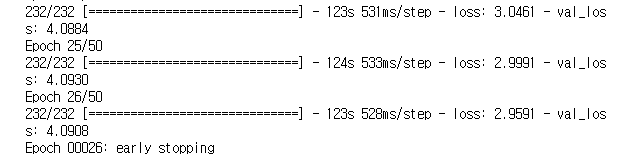

text_max_len = 42 & headlines_max_len = 9
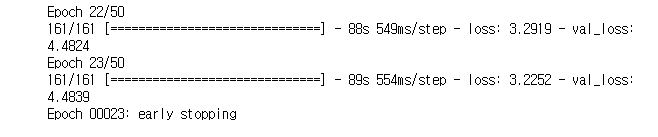


text_max_len = 40 & headlines_max_len = 10

    원문1.
    인도 최초의 남자 하키 월드컵 3위, 첫 두 번의 월드컵 3위를 각각 차지한 인도는 현재까지 라이벌 파키스탄을 물리치고 최종 3회 클린치 하키 월드컵 우승을 차지한 인도 하키팀 올림픽 8관왕이다.
    실제 요약:인도는 첫 번째 하키 세계에서 경기를 마쳤다.
    예측 요약: 인도가 인도를 꺾고 월드컵 결승에 오르다

    원문2.
    전국녹색법원은 화요일 여성 2륜차의 홀짝수 계획을 기각하고 델리 정부가 자의적인 면제를 제안했다.ngt는 여성버스가 직면한 교통문제를 해결할 수 있는 이유를 물었다.

    실제 요약 ::ngt는 홀수 짝수 여자 휠러 거부
    예측 요약: 정부는 세금 학살에 대한 세부사항을 요구한다

text_max_len = 42 & headlines_max_len = 9

    원문 : 인도 캡틴 Virat Kohli는 타임 잡지의 연간 영향력 있는 사람들의 목록을 만들었다 처음으로 크리켓 전설 사친 텐둘카에 이어 3번째로 가장 높은 형식의 달력에 걸쳐 끝났다 콜리 배고픔의 연속성은 게임이 된다고 썼다.
    실제 요약 : 당대 가장 영향력 있는 사람들 사이에 비라트.
    예측 요약 :  kohli named india most expensive at india


    원문 : 전 세계 수천명의 사람들이 토요일 일본 선거 운동인 호주와 같은 몇몇 국가들이 지난 달 학교에서 발생한 총기 폭력에 대한 강력한 규제로 총기 폭력을 중단하라고 요구하는 시위를 벌였다.
    실제 요약 :수천명의 시위대가 총기 폭력 종식을 요구하며 전세계적으로 행진하고 있다.
    예측 요약 :  인도 군대, 열병식에 참가하다
    
    
---- 
## 회고
그래프를 보고 많은 데이터들이 있는 부분을 살리고 데이터가 비교적 작은 곳을 하기 처리하기 위해 text_max_len & headlines_max_len 을 변경해 보았는데 많은 데이터를 살렸을때가 더 높은 로스와 더욱 부자연 스러운 요약이 이루어주는 것으을 보고 많은 데이터를 살린다고 좋은 결과가 나오는 것이 아니라는 것을 깨닫게 되었다.
